## Import Required Libraries

In [2]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torchinfo import summary
import seaborn as sns
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import string

from PreprocessAudio import PreprocessAudio
from model import CRNN

## Load Metadatas

In [4]:
df = pd.read_csv('./common_voice_id/dev.tsv', sep='\t')
df2 = pd.read_csv('./common_voice_id/invalidated.tsv', sep='\t')
df3 = pd.read_csv('./common_voice_id/other.tsv', sep='\t')
df4 = pd.read_csv('./common_voice_id/train.tsv', sep='\t')

df = df[['path', 'sentence']]
df2 = df2[['path', 'sentence']]
df3 = df3[['path', 'sentence']]
df4 = df4[['path', 'sentence']]

df = pd.concat([df, df2, df3, df4], ignore_index=True)
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)

In [5]:
df = df[:1000] # We test it using 1000 data first

## Clean Transcription Text (Remove Any Punctuations and Convert to Lowercase)

In [6]:
def remove_strips(text):
    # Mengganti tanda hubung (-) dengan spasi dan menghapus tanda baca di awal dan akhir kata
    cleaned_text = text.replace('-', ' ').strip(string.punctuation)
    return cleaned_text

for i in range(len(df['sentence'])):
    # print(text)
    df['sentence'][i] = df['sentence'][i].lower()
    df['sentence'][i] = ' '.join(word.strip(string.punctuation) for word in df['sentence'][i].split())
    df['sentence'][i] = ' '.join(remove_strips(word) for word in df['sentence'][i].split())

In [7]:
df.head()

,path,sentence
0,common_voice_id_26747327.mp3,kamu harus melakukannya suka tidak suka
1,common_voice_id_21699230.mp3,saya dibonceng di belakang sepeda teman
2,common_voice_id_25248896.mp3,tom berkata dia dapat menunggu lama
3,common_voice_id_25537482.mp3,minggu lalu terus menerus hujan
4,common_voice_id_21195036.mp3,saat libur musim panas tahun ini saya pergi ke...


## Copy Every Audio File to audio_folder For Further Operations

In [8]:
label_list = []
HOME = os.getcwd()
for i in range(len(df)):
    os.system(f'copy \"{HOME}\\common_voice_id\\clips\\{df["path"][i]}\" \"{HOME}\\audio_folder\\{df["path"][i]}\"')
    label_list.append(df['sentence'][i])

In [9]:
print(f'Banyaknya label: {len(label_list)}')
print('Sampel 10 label')
label_list[:10]

Banyaknya label: 1000
Sampel 10 label


['kamu harus melakukannya suka tidak suka',
 'saya dibonceng di belakang sepeda teman',
 'tom berkata dia dapat menunggu lama',
 'minggu lalu terus menerus hujan',
 'saat libur musim panas tahun ini saya pergi ke laut dan mendaki gunung',
 'dia memanggil namanya',
 'saat berada di sana saya belajar bahasa inggris',
 'di mana kamu membeli buku itu',
 'sepuluh tahun adalah waktu yang lama untuk menunggu',
 'di atas meja ada vas bunga']

In [10]:
label_list_len = [] # List untuk menyimpan kumpulan banyaknya karakter per data
for text in label_list:
    label_list_len.append(len(text))

In [11]:
print(f'Teks terpanjang: {np.max(label_list_len)} karakter')
print(f'Indeks teks terpanjang: {np.argmax(label_list_len)}')

Teks terpanjang: 145 karakter
Indeks teks terpanjang: 387


## Build Functions to Encode and Decode Characters

In [12]:
alphabet = 'abcdefghijklmnopqrstuvwxyz '
num_alpha = len(alphabet) + 1
num_timestamps = 256
max_str_len = 256 

def conv2num(label):
    label_enc = []
    for i in label:
        label_enc.append(alphabet.find(i))
    return np.array(label_enc)

def num2label(num):
    txt = ""
    for i in num:
        if i == -1:
            break
        else:
            txt += alphabet[i]

In [14]:
print(label_list[0])
print(conv2num(label_list[387]))

kamu harus melakukannya suka tidak suka
[ 9  0 11  0 13 26  8 13  8 26  1  4 17 11  0 13  9 20 19 26 12  4 13 20
  9 20 26  0 17  0  7 26 20 19  0 17  0 26  1  0 17  0 19 26 11  0 20 19
 26 18  4 19  4 11  0  7 26 12  4 11  4 22  0 19  8 26 15  0  3  0 13  6
 26 17 20 12 15 20 19 26  1 11 14 14 12  8 13  6 26 12  4 11  0 11 20  8
 26  0 17  0  7 26  3  4 13  6  0 13 26 18  4  1  0  6  8  0 13 26  1  4
 18  0 17 26 15  4 12  0 13  3  0 13  6  0 13 26 15  4 17 19  0 13  8  0
 13]


## Train and Validation Data Split

In [15]:
df_train = df[:800]
df_valid = df[800:]

In [16]:
df_train.iloc[58]

path          common_voice_id_25451716.mp3
sentence    masalah ini tidak akan selesai
Name: 58, dtype: object

In [17]:
df_valid = df_valid.reset_index(drop=True)

In [18]:
# Copy train audio data to 'train' folder
label_list_train = []

for i in range(len(df_train)):
    os.system(f'move \"{HOME}\\audio_folder\\{df_train["path"][i]}\" \"{HOME}\\audio_folder\\train\\{df_train["path"][i]}\"')
    label_list_train.append(df_train['sentence'][i])

In [19]:
# Copy train audio data to 'valid' folder
label_list_valid = []

for i in range(len(df_valid)):
    os.system(f'move \"{HOME}\\audio_folder\\{df_valid["path"][i]}\" \"{HOME}\\audio_folder\\valid\\{df_valid["path"][i]}\"')
    label_list_valid.append(df_valid['sentence'][i])

In [20]:
train_size = len(label_list_train) # Bisa diganti
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_timestamps - 2) # -2 bisa diganti2 juga
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(label_list_train[i])
    train_y[i, 0:len(label_list_train[i])]= conv2num(label_list_train[i])    

In [21]:
valid_size = len(label_list_valid) # Bisa diganti
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_timestamps - 2) # -2 bisa diganti2 juga
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(label_list_valid[i])
    valid_y[i, 0:len(label_list_valid[i])]= conv2num(label_list_valid[i])    

In [22]:
ll_train = [] # Train label lengths list
ll_valid = []
for txt in label_list_train:
    ll_train.append(len(txt))

for txt in label_list_valid:
    ll_valid.append(len(txt))

In [23]:
np.argmax(ll_train) # Maximum length of train set

387

In [24]:
print(train_y[np.argmax(ll_train)]) # Label terpanjang
print(train_label_len[np.argmax(ll_train)])
print(train_input_len[np.argmax(ll_train)])
print(train_output[np.argmax(ll_train)])

[ 9.  0. 11.  0. 13. 26.  8. 13.  8. 26.  1.  4. 17. 11.  0. 13.  9. 20.
 19. 26. 12.  4. 13. 20.  9. 20. 26.  0. 17.  0.  7. 26. 20. 19.  0. 17.
  0. 26.  1.  0. 17.  0. 19. 26. 11.  0. 20. 19. 26. 18.  4. 19.  4. 11.
  0.  7. 26. 12.  4. 11.  4. 22.  0. 19.  8. 26. 15.  0.  3.  0. 13.  6.
 26. 17. 20. 12. 15. 20. 19. 26.  1. 11. 14. 14. 12.  8. 13.  6. 26. 12.
  4. 11.  0. 11. 20.  8. 26.  0. 17.  0.  7. 26.  3.  4. 13.  6.  0. 13.
 26. 18.  4.  1.  0.  6.  8.  0. 13. 26.  1.  4. 18.  0. 17. 26. 15.  4.
 12.  0. 13.  3.  0. 13.  6.  0. 13. 26. 15.  4. 17. 19.  0. 13.  8.  0.
 13. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1

## Preprocess Audio to Obtain MFCC Matrices

In [25]:
PipelineTrain = PreprocessAudio('./audio_folder/train/', df_train)
PipelineValid = PreprocessAudio('./audio_folder/valid/', df_valid)

In [26]:
dataset_train, file_error_train, index_error_train, df_train_filtered = PipelineTrain.load_audio()
dataset_valid, file_error_valid, index_error_valid, df_valid_filtered = PipelineValid.load_audio()

Mounted audio directory at: ./audio_folder/train/


C:\Users\Kevin Putra Santoso\Documents\IVR_Project\PreprocessAudio.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor([signal])


Error di file ./audio_folder/train/common_voice_id_25470004.mp3
Counter di 12
Error di file ./audio_folder/train/common_voice_id_21699467.mp3
Counter di 72
Error di file ./audio_folder/train/common_voice_id_35338065.mp3
Counter di 156
Error di file ./audio_folder/train/common_voice_id_26242833.mp3
Counter di 162
Error di file ./audio_folder/train/common_voice_id_26237570.mp3
Counter di 173
Error di file ./audio_folder/train/common_voice_id_19783809.mp3
Counter di 189
Error di file ./audio_folder/train/common_voice_id_21194463.mp3
Counter di 203
Error di file ./audio_folder/train/common_voice_id_25469455.mp3
Counter di 307
Error di file ./audio_folder/train/common_voice_id_21194346.mp3
Counter di 426
Error di file ./audio_folder/train/common_voice_id_20847480.mp3
Counter di 492
Error di file ./audio_folder/train/common_voice_id_21587706.mp3
Counter di 497
Error di file ./audio_folder/train/common_voice_id_21192699.mp3
Counter di 498
Error di file ./audio_folder/train/common_voice_id_217

We saw several error here because those audio files are failed to be processed on VAD since there are no significant wave activities, so they are considered as silence periods that shall be removed.

In [27]:
file_error_train

['./audio_folder/train/common_voice_id_25470004.mp3',
 './audio_folder/train/common_voice_id_21699467.mp3',
 './audio_folder/train/common_voice_id_35338065.mp3',
 './audio_folder/train/common_voice_id_26242833.mp3',
 './audio_folder/train/common_voice_id_26237570.mp3',
 './audio_folder/train/common_voice_id_19783809.mp3',
 './audio_folder/train/common_voice_id_21194463.mp3',
 './audio_folder/train/common_voice_id_25469455.mp3',
 './audio_folder/train/common_voice_id_21194346.mp3',
 './audio_folder/train/common_voice_id_20847480.mp3',
 './audio_folder/train/common_voice_id_21587706.mp3',
 './audio_folder/train/common_voice_id_21192699.mp3',
 './audio_folder/train/common_voice_id_21705450.mp3',
 './audio_folder/train/common_voice_id_26228662.mp3',
 './audio_folder/train/common_voice_id_21194442.mp3',
 './audio_folder/train/common_voice_id_25469861.mp3']

In [28]:
# Check whether the sum of error audios are correct
print(len(file_error_train))
print(len(index_error_train))
print(len(df_train) - len(df_train_filtered))

16
16
16


In [29]:
list_len_data_train = []
for i in range(len(dataset_train)):
    list_len_data_train.append(np.array(dataset_train[i][0]).shape[0])
    
list_len_transkrip_train = []
for text in df_train_filtered['sentence']:
    list_len_transkrip_train.append(len(text))

list_len_data_valid = []
for i in range(len(dataset_valid)):
    list_len_data_valid.append(np.array(dataset_valid[i][0]).shape[0])
    
list_len_transkrip_valid = []
for text in df_valid_filtered['sentence']:
    list_len_transkrip_valid.append(len(text))

df_komparasi_len_train = pd.DataFrame({'len_mfcc':list_len_data_train, 'len_transkrip':list_len_transkrip_train})
df_komparasi_len_valid = pd.DataFrame({'len_mfcc':list_len_data_valid, 'len_transkrip':list_len_transkrip_valid})

In [30]:
df_komparasi_len_train.head(20)

,len_mfcc,len_transkrip
0,180,39
1,16,39
2,157,35
3,149,31
4,8,70
5,110,21
6,126,47
7,110,29
8,157,51
9,94,26


In [31]:
df_komparasi_len_valid.head(20)

,len_mfcc,len_transkrip
0,282,65
1,133,39
2,79,24
3,32,5
4,219,50
5,79,19
6,32,63
7,149,41
8,63,14
9,305,65


In [32]:
df_komparasi_len_train.describe()

,len_mfcc,len_transkrip
count,784.000000,784.000000
mean,154.363520,40.984694
std,77.961688,19.787757
min,8.000000,3.000000
25%,102.000000,27.000000
50%,141.000000,38.000000
75%,196.000000,50.000000
max,524.000000,145.000000


In [33]:
df_komparasi_len_valid.describe()

,len_mfcc,len_transkrip
count,199.000000,199.000000
mean,149.170854,41.502513
std,78.736878,20.354156
min,8.000000,4.000000
25%,98.000000,27.000000
50%,133.000000,36.000000
75%,188.000000,52.500000
max,493.000000,109.000000


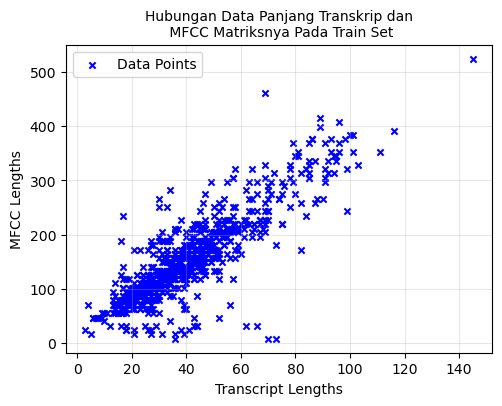

In [34]:
plt.figure(figsize=(5.5, 4))
plt.title('Hubungan Data Panjang Transkrip dan\n MFCC Matriksnya Pada Train Set', fontsize=10)
plt.scatter(df_komparasi_len_train['len_transkrip'], df_komparasi_len_train['len_mfcc'], c='b', s=20, marker='x', label='Data Points')
plt.xlabel('Transcript Lengths')
plt.ylabel('MFCC Lengths')
plt.grid(which='major', alpha=0.3)
plt.legend()
plt.show()

The scatter plot reveals the presence of several outliers in the dataset. These outliers suggest the existence of audio files that may have excessive noise (indicated by high MFCC timesteps and a small transcript length) or lack speech entirely (indicated by low MFCC timesteps and a high transcript length). To address this issue, we intend to employ linear regression to model the plot and subsequently eliminate any data points that significantly deviate from the fitted linear line.

In [35]:
from sklearn.linear_model import LinearRegression

linreg_model = LinearRegression()
linreg_model.fit(np.array(df_komparasi_len_train['len_transkrip']).reshape(-1, 1), np.array(df_komparasi_len_train['len_mfcc']).reshape(-1,1))
preds = linreg_model.predict(np.array(df_komparasi_len_train['len_transkrip']).reshape(-1, 1))

In [36]:
print(linreg_model.coef_)
print(linreg_model.intercept_)

[[3.34628549]]
[17.21703383]


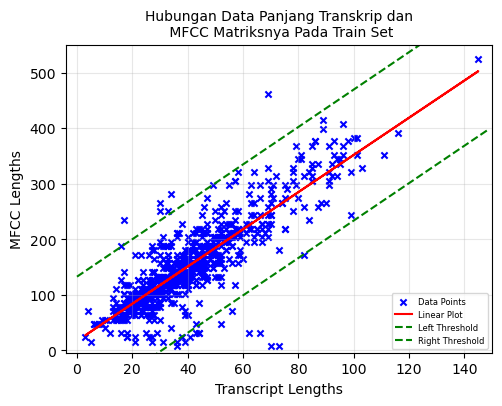

In [37]:
plt.figure(figsize=(5.5, 4))
plt.title('Hubungan Data Panjang Transkrip dan\n MFCC Matriksnya Pada Train Set', fontsize=10)
plt.scatter(df_komparasi_len_train['len_transkrip'], df_komparasi_len_train['len_mfcc'], c='b', s=20, marker='x', label='Data Points')
plt.plot(df_komparasi_len_train['len_transkrip'], preds, 'r-', label='Linear Plot')
x = np.arange(0, 150)
plt.plot(x, 3.36606827 * (x + 35) + 14.98861941, 'g--',label='Left Threshold')
plt.plot(x, 3.36606827 * (x - 35) + 14.98861941, 'g--',label='Right Threshold')
plt.xlabel('Transcript Lengths')
plt.ylabel('MFCC Lengths')
plt.xlim([-4,150])
plt.ylim([-4,550])
plt.grid(which='major', alpha=0.3)
plt.legend(loc='lower right', prop={'size':6})
plt.show()

In [38]:
def calculate_distance(x, y, m, c):
    return abs(y - (m * x + c)) / np.sqrt(m**2 + 1)

def remove_outliers(df, P):
    m, c = np.polyfit(df['len_transkrip'], df['len_mfcc'], 1)
    df['distance'] = calculate_distance(df['len_transkrip'], df['len_mfcc'], m, c)
    return df[df['distance'] <= P].drop(columns=['distance'])

P = 35

df = df_komparasi_len_train.copy()
df_cleaned = remove_outliers(df, P)

In [39]:
df.head(10)

,len_mfcc,len_transkrip,distance
0,180,39,9.242015
1,16,39,37.715616
2,157,35,6.489022
3,149,31,8.030933
4,8,70,69.708322
5,110,21,6.445499
6,126,47,13.884699
7,110,29,1.219556
8,157,51,8.841089
9,94,26,2.926393


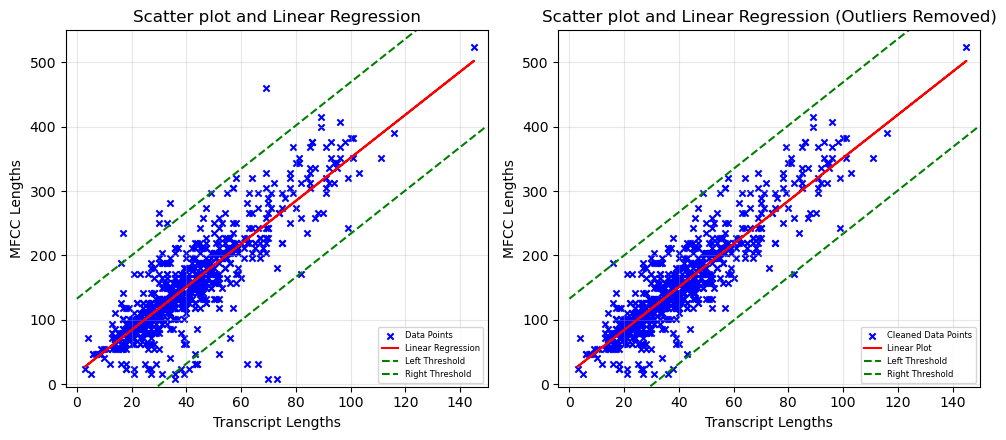

In [60]:
plt.figure(figsize=(10, 4.5))
plt.subplot(1,2,1)
plt.scatter(df['len_transkrip'], df['len_mfcc'], c='b', s=20, marker='x', label='Data Points')
plt.plot(df['len_transkrip'], np.polyval(np.polyfit(df['len_transkrip'], df['len_mfcc'], 1), df['len_transkrip']), color='r', label='Linear Regression')
plt.plot(x, 3.36606827*(x + P) + 14.98861941, 'g--',label='Left Threshold')
plt.plot(x, 3.36606827*(x - P) + 14.98861941, 'g--',label='Right Threshold')
plt.xlabel('Transcript Lengths')
plt.ylabel('MFCC Lengths')
plt.xlim([-4,150])
plt.ylim([-4,550])
plt.legend(loc='lower right', prop={'size':6})
plt.title('Scatter plot and Linear Regression')
plt.grid(which='major', alpha=0.3)

plt.subplot(1,2,2)
plt.scatter(df_cleaned['len_transkrip'], df_cleaned['len_mfcc'], c='b', s=20, marker='x', label='Cleaned Data Points')
plt.plot(df_komparasi_len_train['len_transkrip'], preds, 'r-', label='Linear Plot')
plt.plot(x, 3.36606827*(x + P) + 14.98861941, 'g--',label='Left Threshold')
plt.plot(x, 3.36606827*(x - P) + 14.98861941, 'g--',label='Right Threshold')
plt.xlabel('Transcript Lengths')
plt.ylabel('MFCC Lengths')
plt.xlim([-4,150])
plt.ylim([-4,550])
plt.legend(loc='lower right', prop={'size':6})
plt.title('Scatter plot and Linear Regression (Outliers Removed)')
plt.grid(which='major', alpha=0.3)

plt.tight_layout()
plt.show()

In [41]:
print(f"Number of dropped dataset: {len(df_komparasi_len_train) - len(df_cleaned)}")

Number of dropped dataset: 18


In [42]:
cleaned_index = pd.Series(df_cleaned.index.tolist())
uncleaned_index = pd.Series(df_train_filtered.index.tolist())

In [43]:
not_cleaned_index = uncleaned_index[~uncleaned_index.isin(cleaned_index)].tolist()

In [44]:
df_train_filtered.loc[not_cleaned_index]

,path,sentence
1,common_voice_id_21699230.mp3,saya dibonceng di belakang sepeda teman
4,common_voice_id_21195036.mp3,saat libur musim panas tahun ini saya pergi ke...
13,common_voice_id_19648040.mp3,tom terlihat seperti sedang sedih
38,common_voice_id_19821432.mp3,saya melihat film
54,common_voice_id_20953394.mp3,istri pak tanaka dosen universitas
160,common_voice_id_21700142.mp3,pak kimura kadang kadang membuat makan malam
191,common_voice_id_26019217.mp3,ingebrigtsen menulis lagu true friendship untu...
201,common_voice_id_25469772.mp3,aku suka menyikat gigi dengan pasta gigi ini
278,common_voice_id_21698845.mp3,percayakah anda bahwa takdir takdir kita dipen...
320,common_voice_id_21699828.mp3,kemarin saya tidak pergi ke perusahaan tetapi ...


In [45]:
df_train_filtered_cleaned = df_train_filtered.loc[cleaned_index].reset_index(drop=True)

In [46]:
df_train_filtered_cleaned.to_csv('df_train_filtered_polyfit_sampel2693.csv', index=False)

In [59]:
print(np.max(list_len_data_train)) # This should be fixed
print(np.argmax(list_len_data_train)) 

524
379


## Add Paddings to Tensors

In [54]:
def add_padding(mfcc_tensor, index):
    height, width = np.array(mfcc_tensor[index][0]).shape[0], np.array(mfcc_tensor[index][0]).shape[1]
    
    padded_mfcc = np.zeros([524, 64])
    padded_mfcc[:height, :width] = mfcc_tensor[index][0]
    return padded_mfcc

In [55]:
print(df_train_filtered.iloc[1])
print(df_train_filtered.iloc[4])

path                   common_voice_id_21699230.mp3
sentence    saya dibonceng di belakang sepeda teman
Name: 1, dtype: object
path                             common_voice_id_21195036.mp3
sentence    saat libur musim panas tahun ini saya pergi ke...
Name: 4, dtype: object


In [56]:
len(dataset_train)

784

In [57]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    fig.set_figheight(4)
    fig.set_figwidth(8)
    axs.set_title(title)
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

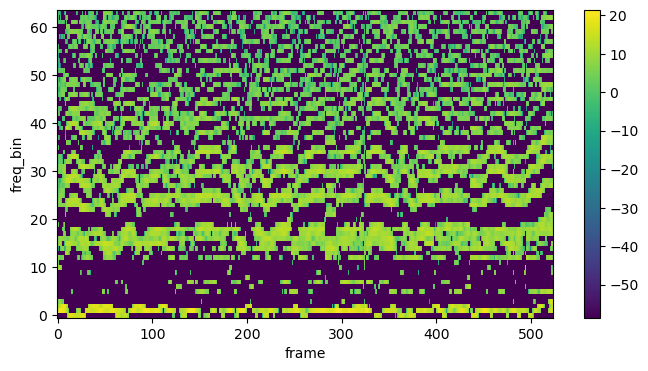

In [58]:
import librosa
plot_spectrogram(add_padding(dataset_train, 379).T)

In [29]:
train_dataset_list = []
for i in range(len(dataset)):
    dataset_list.append([add_padding(dataset_train, i).tolist()])

In [30]:
dataset_list = torch.tensor(dataset_list)

In [31]:
dataset_list.shape

torch.Size([2056, 1, 512, 64])

In [32]:
num_alpha = 28

In [258]:
dataset_list = dataset_list.to(device)

## Prepare Model

In [3]:
num_classes = 28
batch_size = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN(num_classes).to(device)
sample_input = torch.randn(batch_size, 1, 512, 64).to(device)
print(summary(model, input_size=(batch_size, 1, 512, 64)))
print('---------------- SAMPLE OUTPUT -----------------')
print(model(torch.randn(batch_size, 1, 512, 64).to(device)))

Layer (type:depth-idx)                   Output Shape              Param #
CRNN                                     [8, 256, 28]              --
├─Conv2d: 1-1                            [8, 64, 512, 64]          640
├─BatchNorm2d: 1-2                       [8, 64, 512, 64]          128
├─MaxPool2d: 1-3                         [8, 64, 256, 32]          --
├─Conv2d: 1-4                            [8, 128, 256, 32]         73,856
├─BatchNorm2d: 1-5                       [8, 128, 256, 32]         256
├─MaxPool2d: 1-6                         [8, 128, 128, 16]         --
├─Dropout2d: 1-7                         [8, 128, 128, 16]         --
├─Conv2d: 1-8                            [8, 256, 128, 16]         295,168
├─BatchNorm2d: 1-9                       [8, 256, 128, 16]         512
├─MaxPool2d: 1-10                        [8, 256, 64, 8]           --
├─Dropout2d: 1-11                        [8, 256, 64, 8]           --
├─Linear: 1-12                           [8, 256, 512]             262,6

In [189]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

class YourCustomDataset():
    def __init__(self, dataset_list, train_y):
        self.dataset_list = dataset_list
        self.train_y = train_y

    def __len__(self):
        return len(self.dataset_list)

    def __getitem__(self, idx):
        return self.dataset_list[idx], self.train_y[idx], 256, 256

batch_size = 8  # Modify as needed
dataset = YourCustomDataset(dataset_list, train_y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

lr = 5e-4
criterion = nn.CTCLoss(blank=27, zero_infinity=False)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0.0
    num_batches = len(dataloader)

    for batch_idx, (batch_data, batch_labels) in enumerate(dataloader):
        batch_data = batch_data.to(device)
        optimizer.zero_grad()
        output = model(batch_data)

        output_length = torch.full((batch_data.size(0),), output.size(1), dtype=torch.long)
        label_length = torch.tensor([len(label) for label in batch_labels], dtype=torch.long)

        batch_labels_padded = pad_sequence(batch_labels, batch_first=True)

        output = output.permute(1, 0, 2)

        loss = criterion(output, batch_labels_padded, output_length, label_length)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        avg_loss = total_loss / (batch_idx + 1)

        print(f"Epoch [{epoch + 1}/{num_epochs}] Batch [{batch_idx + 1}/{num_batches}] Loss: {loss.item():.4f} Avg Loss: {avg_loss:.4f}")

    print(f"Epoch [{epoch + 1}/{num_epochs}] Average Loss: {avg_loss:.4f}")

print("Training finished!")

Epoch [1/10] Batch [1/257] Loss: nan Avg Loss: nan
Epoch [1/10] Batch [2/257] Loss: nan Avg Loss: nan
Epoch [1/10] Batch [3/257] Loss: nan Avg Loss: nan
Epoch [1/10] Batch [4/257] Loss: nan Avg Loss: nan
Epoch [1/10] Batch [5/257] Loss: nan Avg Loss: nan
Epoch [1/10] Batch [6/257] Loss: nan Avg Loss: nan
Epoch [1/10] Batch [7/257] Loss: nan Avg Loss: nan
Epoch [1/10] Batch [8/257] Loss: nan Avg Loss: nan
Epoch [1/10] Batch [9/257] Loss: nan Avg Loss: nan
Epoch [1/10] Batch [10/257] Loss: nan Avg Loss: nan
Epoch [1/10] Batch [11/257] Loss: nan Avg Loss: nan
Epoch [1/10] Batch [12/257] Loss: nan Avg Loss: nan
Epoch [1/10] Batch [13/257] Loss: nan Avg Loss: nan
Epoch [1/10] Batch [14/257] Loss: nan Avg Loss: nan
Epoch [1/10] Batch [15/257] Loss: nan Avg Loss: nan
Epoch [1/10] Batch [16/257] Loss: nan Avg Loss: nan
Epoch [1/10] Batch [17/257] Loss: nan Avg Loss: nan
Epoch [1/10] Batch [18/257] Loss: nan Avg Loss: nan
Epoch [1/10] Batch [19/257] Loss: nan Avg Loss: nan
Epoch [1/10] Batch [2

KeyboardInterrupt: 

In [89]:
print(train_y.shape)
print(dataset_list.shape)

(2056, 256)
torch.Size([2056, 1, 512, 64])


In [88]:
train_y = train_y[:2056]

In [205]:
class YourCustomDataset():
    def __init__(self, dataset_list, train_y):
        self.dataset_list = dataset_list
        self.train_y = train_y

    def __len__(self):
        return len(self.dataset_list)

    def __getitem__(self, idx):
        return self.dataset_list[idx], self.train_y[idx], 8, 256


In [206]:
def ctc_loss(log_probs, targets, input_lengths, target_lengths):
    ctc_loss = nn.CTCLoss(blank=num_classes - 1)  # Use num_classes - 1 as the index for the blank symbol
    return ctc_loss(log_probs, targets, input_lengths, target_lengths)

# Hyperparameters
num_classes = 28
batch_size = 8
num_epochs = 10
learning_rate = 0.001

# Initialize the model, optimizer, and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = A_CRNN(num_classes, batch_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Assuming you have a custom dataset named 'your_dataset', and you have already split it into train and test sets
train_dataset = YourCustomDataset(dataset_list, train_y)  # Modify this as per your dataset class
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (inputs, targets, input_lengths, target_lengths) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate CTC loss
        input_lengths = torch.full(size=(inputs.size(0),), fill_value=inputs.size(2), dtype=torch.long)  # MFCC matrix width
        target_lengths = target_lengths.to(torch.long)
        loss = ctc_loss(outputs, targets, input_lengths, target_lengths)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}")

# Save the trained model
torch.save(model.state_dict(), "trained_model.pt")

RuntimeError: input_lengths must be of size batch_size

In [251]:
y_pred = model(batch_data)
y_pred = y_pred.permute(1, 0, 2)
batch_size = 8
model = A_CRNN(num_classes, batch_size).to(device)
# Calculate CTC loss
ctc_loss = F.ctc_loss(model(batch_data), 
                      batch_labels, torch.tensor([1]), label_length)

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 8.00 GiB total capacity; 7.15 GiB already allocated; 0 bytes free; 7.30 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [222]:
torch.tensor([batch_data[0].tolist()]).shape

torch.Size([1, 1, 512, 64])

In [231]:
output_length - 256 + 8

tensor([8, 8, 8, 8, 8, 8, 8, 8])

In [245]:
torch.tensor([batch_data[0].tolist()]).shape

torch.Size([1, 1, 512, 64])